# Instance segmentation 

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
plt.rcParams["savefig.bbox"] = 'tight'
device = torch.device('cuda')

## Data Import & visualization

In [2]:
from torchvision.utils import make_grid
from torchvision.io import read_image
import torchvision.transforms as T
from pathlib import Path

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])


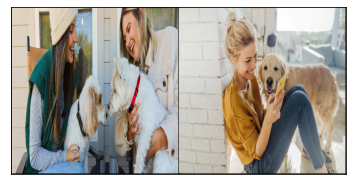

In [3]:
image_1 = read_image(str(Path('drive/MyDrive/Computer_vision_data') / 'dog3.png'))
image_2 = read_image(str(Path('drive/MyDrive/Computer_vision_data') / 'dog2.jpg'))
image_list = [T.Resize(size=(600,600))(image_1),T.Resize(size=(600,600))(image_2)]
grid = make_grid(image_list) # return a tensor containing a grid of images
show(grid)

## Model loading

In [4]:
from torchvision.models.detection import maskrcnn_resnet50_fpn, MaskRCNN_ResNet50_FPN_Weights

weights = MaskRCNN_ResNet50_FPN_Weights.DEFAULT
transforms = weights.transforms()
model = maskrcnn_resnet50_fpn(weights=weights, progress=False).to(device)
model = model.eval()

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


##Input preprocessing

In [5]:
images = [transforms(d).to(device) for d in image_list]

In [6]:
len(images)

2

In [7]:
for image in images:
  print(image.shape)

torch.Size([3, 600, 600])
torch.Size([3, 600, 600])


## Inference

In [8]:
output = model(images) # list of dict
print(len(output)) # == batchsize

2


## Output inspection

In [9]:
output[0].keys() # boxes,labels,scores,masks

dict_keys(['boxes', 'labels', 'scores', 'masks'])

In [10]:
len(output[0].get('boxes'))

31

In [11]:
len(output[0].get('labels'))

31

In [12]:
output[0].get('scores')

tensor([0.9846, 0.8334, 0.8141, 0.7224, 0.6608, 0.6413, 0.4271, 0.3636, 0.3185,
        0.2632, 0.2181, 0.1829, 0.1716, 0.1601, 0.1331, 0.1242, 0.1068, 0.1042,
        0.0987, 0.0853, 0.0767, 0.0724, 0.0698, 0.0682, 0.0593, 0.0579, 0.0574,
        0.0518, 0.0518, 0.0506, 0.0501], device='cuda:0',
       grad_fn=<IndexBackward0>)

In [13]:
len(output[0].get('masks'))

31

In [14]:
def inspect_model_output(output):
  for index,prediction in enumerate(output):
    print(f'Input {index + 1} has { len(prediction.get("scores")) } detected instances')

In [15]:
inspect_model_output(output)

Input 1 has 31 detected instances
Input 2 has 21 detected instances


## Output preprocessing

In [16]:
from torchvision.utils import draw_bounding_boxes
from torchvision.utils import draw_segmentation_masks

def filter_model_output(output,score_threshold):
  filtred_output = list()
  for image in output:
    filtred_image = dict()
    for key in image.keys():
      filtred_image[key] = image[key][image['scores'] >= score_threshold]
    filtred_output.append(filtred_image)
  return filtred_output

def get_boolean_mask(output):
  for index,pred in enumerate(output):
    output[index]['masks'] = pred['masks'] > 0.5
    output[index]['masks'] = output[index]['masks'].squeeze(1)
  return output

In [17]:
score_threshold = .8

In [18]:
output = filter_model_output(output=output,score_threshold=score_threshold)
output = get_boolean_mask(output)

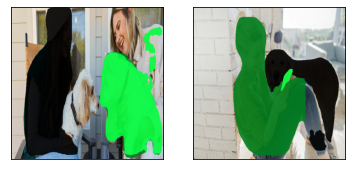

In [19]:
show([
    draw_segmentation_masks(image, prediction.get('masks'), alpha=0.9)
    for index, (image, prediction) in enumerate(zip(image_list, output))
])